## Load environment and libraries
This cell loads environment variables from `sample_gemini.env` and imports libraries used later. If you don't have `python-dotenv`, `requests`, `google-generativeai`, or `openai` installed, run the following command in your environment:
```
pip install python-dotenv requests google-generativeai openai
```

In [10]:
from dotenv import load_dotenv
import os
import requests
import json

# Load the env file shipped with this notebook (edit it with your key & model)
load_dotenv('sample_gemini.env')
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
GEMINI_MODEL = os.getenv('GEMINI_MODEL', 'text-bison-001')  # Default to free-tier model

print('GEMINI_API_KEY present:', bool(GEMINI_API_KEY))
print('Using model:', GEMINI_MODEL)

GEMINI_API_KEY present: True
Using model: openrouter/sherlock-dash-alpha


## Low-dependency Gemini caller
This cell defines `call_gemini(prompt)` which first tries to use the `google.generativeai` Python package if available and falls back to a simple REST `requests` call to the Generative Language endpoint. The function returns plain text output when possible.

In [ ]:
import json

def call_gemini(prompt, model=GEMINI_MODEL, api_key=GEMINI_API_KEY, max_tokens=512):
    """Call OpenRouter API using openai-python client."""
    if not api_key:
        raise ValueError('GEMINI_API_KEY is not set. Add it to sample_gemini.env')

    from openai import OpenAI

    client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=api_key,
    )

    completion = client.chat.completions.create(
        extra_headers={
            "HTTP-Referer": "https://example.com/",  # Optional
            "X-Title": "Example"  # Optional
        },
        extra_body={},
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    }
                ]
            }
        ]
    )

    return completion.choices[0].message.content

# Example usage
# response = call_gemini("What is Python?")
# print("Response Content:", response)


# LangGraph Integration: Node Definitions

We'll now refactor the workflow to use LangGraph. Each step will be a node function, and the graph will manage state and transitions.

First, ensure you have LangGraph installed:
```
pip install langgraph
```

Next, we'll import LangGraph and define the node functions for each step.

In [12]:
# Import LangGraph and define node functions
from langgraph.graph import StateGraph
import re

# Define state structure
class RoadmapState:
    def __init__(self):
        self.topic = None
        self.goal = None
        self.learning_style = None
        self.available_time = None
        self.roadmap = None
        self.feedback = None
        self.revised_roadmap = None
        # Only use estimated_level (A1, A2, B1, B2, C1, C2, None)
        self.estimated_level = None
        self.prereqs_needed = None
        self.primer = None
        self.schedule = None
        self.target_duration_weeks = None
        self.resources = None
        # Enhancement: progress tracking fields
        self.module_progress = {}  # {module_name: {'status': str, 'completed_at': timestamp}}
        self.quiz_scores = []      # [{'quiz': str, 'score': int, 'timestamp': str}]
        self.timestamps = {}       # {'started': str, 'completed': str, ...}

    def to_dict(self):
        """Return a JSON-serializable dict representing the state."""
        return {
            'topic': self.topic,
            'goal': self.goal,
            'learning_style': self.learning_style,
            'available_time': self.available_time,
            'roadmap': self.roadmap,
            'feedback': self.feedback,
            'revised_roadmap': self.revised_roadmap,
            'estimated_level': self.estimated_level,
            'prereqs_needed': self.prereqs_needed,
            'primer': self.primer,
            'schedule': self.schedule,
            'resources': self.resources,
            'target_duration_weeks': self.target_duration_weeks,
            # Progress fields
            'module_progress': self.module_progress,
            'quiz_scores': self.quiz_scores,
            'timestamps': self.timestamps,
        }

    @classmethod
    def from_dict(cls, d: dict):
        """Create a RoadmapState from a dict (ignores unknown keys)."""
        s = cls()
        if not isinstance(d, dict):
            return s
        for k in ('topic','goal','learning_style','available_time','roadmap','feedback','revised_roadmap',
                  'estimated_level','prereqs_needed','primer','schedule','resources','target_duration_weeks',
                  'module_progress','quiz_scores','timestamps'):
            if k in d:
                setattr(s, k, d[k])
        return s

# Node 1: Topic & Goal Selection
def node_topic_goal(state: RoadmapState):
    print("Welcome to the Roadmap/Learning Path Maker!")
    state.topic = input("Enter the topic you want to learn (e.g., Python for Data Science): ")
    state.goal = input("Describe your learning goal (e.g., Get a job, Build a project, Pass a course): ")
    # record start timestamp
    import datetime
    state.timestamps['started'] = datetime.datetime.utcnow().isoformat() + 'Z'
    return state

# Node 1b: Level selection (replaces experience/assessment)
def node_level_selection(state: RoadmapState):
    levels = ['None', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2']
    print("Select your current level for this topic:")
    for i, lvl in enumerate(levels):
        print(f"  {i}: {lvl}")
    idx = input("Enter the number for your level (0-6): ").strip()
    try:
        idx = int(idx)
        if 0 <= idx < len(levels):
            state.estimated_level = levels[idx]
        else:
            state.estimated_level = 'None'
    except Exception:
        state.estimated_level = 'None'
    print(f"Selected level: {state.estimated_level}")
    return state

# Node X: Prerequisite Detection (LLM)
def node_prerequisite_check(state: RoadmapState):
    if not state.topic:
        print('No topic; skipping prerequisite check.')
        return state
    prompt = f"""You are an expert instructor for the topic: {state.topic}.\nList up to 6 concise prerequisite topics or skills a learner should know before starting {state.topic}.\nReturn the prerequisites as a numbered list, one item per line."""
    try:
        prereq_text = call_gemini(prompt)
    except Exception as e:
        print('Prerequisite LLM call failed:', e)
        prereq_text = ''
    print('\n--- PREREQUISITES (LLM) ---\n')
    print(prereq_text)
    prereqs = [line.strip() for line in prereq_text.split('\n') if line.strip() and re.match(r"^\d+\.?\s+", line)]
    if not prereqs:
        prereqs = [line.strip() for line in prereq_text.split('\n') if line.strip()]
    state.prereqs_needed = prereqs
    if prereqs:
        wants_primer = input("Would you like a short primer that covers these prerequisites? (yes/no): ").strip().lower()
        if wants_primer in ('yes','y'):
            primer_prompt = f"""You are an expert instructor. Create a short primer that covers the following prerequisite topics for {state.topic}: {', '.join(prereqs)}. Keep it concise (around 200-400 words) and present as a short numbered list of quick lessons or reading items."""
            try:
                primer_text = call_gemini(primer_prompt)
            except Exception as e:
                print('Primer generation failed:', e)
                primer_text = ''
            print('\n--- PRIMER ---\n')
            print(primer_text)
            state.primer = primer_text
    else:
        print('No prerequisites identified by the model.')
    return state

# Node 3: Roadmap Generation
def node_generate_roadmap(state: RoadmapState):
    feedback_section = ""
    primer_section = ""
    if getattr(state, 'feedback', None) and state.feedback.strip().lower() != 'no':
        feedback_section = f"\nPlease incorporate the following user feedback when revising the roadmap: {state.feedback}\n"
    if getattr(state, 'primer', None):
        primer_section = f"\nThe learner will receive the following primer on prerequisites before starting: {state.primer}\n"
    roadmap_prompt = f"""You are an expert learning designer.\nCreate a concise, actionable learning roadmap for the topic: {state.topic}.\nGoal: {state.goal}.\nLevel: {state.estimated_level}.\nPreferred learning style: {state.learning_style}.\nAvailable time per week: {state.available_time}.\n{primer_section}{feedback_section}Output a short numbered list of 6-10 modules. For each module include: a one-line goal, suggested resources (URLs or short names), and suggested time. Keep it concise and actionable.\nProvide the result as plain text."""
    try:
        state.roadmap = call_gemini(roadmap_prompt)
    except Exception as e:
        print('Roadmap generation failed:', e)
        state.roadmap = ''
    print("\n--- ROADMAP ---\n")
    print(state.roadmap)
    return state

# ...existing code for resource fetcher, review/feedback, adaptive branch, schedule builder, final output, quiz branch, etc. ...

In [13]:
# Branching quiz node: presents a quiz after roadmap generation, updates progress, and branches based on score
import datetime

def node_module_quiz_branch(state: RoadmapState):
    """
    After roadmap generation, present a quiz for each module.
    Branch: If score < threshold, recommend review or extra resources; else, mark module complete.
    Updates state.module_progress and state.quiz_scores.
    """
    if not state.roadmap:
        print('No roadmap found for quiz branching.')
        return state
    modules = []
    for line in state.roadmap.split('\n'):
        m = re.match(r"^\s*\d+\.?\s*(.+)", line)
        if m:
            modules.append(m.group(1).strip())
    if not modules:
        print('No modules found for quiz branching.')
        return state
    for mod in modules:
        print(f"\nModule: {mod}")
        # Generate a quiz for the module using LLM
        quiz_prompt = f"""You are an expert instructor. Create a short 3-question multiple-choice quiz (A/B/C/D) to test understanding of the module: {mod}. Return only the questions, numbered, with choices."""
        quiz_text = call_gemini(quiz_prompt)
        print(quiz_text)
        correct = 0
        answers = []
        for i in range(1, 4):
            ans = input(f"Your answer for Q{i} (A/B/C/D): ").strip().upper()
            answers.append(ans)
        # Score: ask LLM to grade
        grade_prompt = f"""You are an expert instructor. Here are the quiz questions and user answers for the module: {mod}.\nQuestions:\n{quiz_text}\nAnswers: {answers}\nReturn the number of correct answers (0-3) and a brief feedback."""
        grade_text = call_gemini(grade_prompt)
        print(grade_text)
        # Extract score (best-effort)
        score_match = re.search(r"(\d+)", grade_text)
        score = int(score_match.group(1)) if score_match else 0
        timestamp = datetime.datetime.utcnow().isoformat() + 'Z'
        state.quiz_scores.append({'module': mod, 'score': score, 'timestamp': timestamp})
        # Branch: if score < 2, recommend review
        if score < 2:
            print(f"You scored {score}/3. Recommended: review module or try extra resources.")
            state.module_progress[mod] = {'status': 'review recommended', 'completed_at': timestamp}
        else:
            print(f"You scored {score}/3. Module marked complete.")
            state.module_progress[mod] = {'status': 'completed', 'completed_at': timestamp}
    return state


In [14]:
# Node: User Review & Feedback (fix NameError)
def node_review_feedback(state: RoadmapState):
    print("\n--- USER REVIEW & FEEDBACK ---\n")
    print("Here is your generated roadmap:")
    print(state.roadmap)
    feedback = input("Do you want to request changes to the roadmap? If yes, describe them. If no, type 'no': ").strip()
    state.feedback = feedback
    return state

# Generate topic-specific skill level descriptions using Gemini
def get_topic_level_descriptions(topic):
    levels = ['None', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2']
    descriptions = {}
    for lvl in levels:
        prompt = (
            f"For the topic '{topic}', describe what it means to be at the '{lvl}' skill level. "
            "Be specific about the knowledge, skills, and abilities expected at this level. "
            "Keep the description concise and practical for learners."
        )
        try:
            desc = call_gemini(prompt)
        except Exception as e:
            desc = f"Description unavailable for {lvl}: {e}"
        descriptions[lvl] = desc.strip()
    return descriptions

# Update node_level_selection to use topic-specific descriptions
def node_level_selection(state: RoadmapState):
    levels = ['None', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2']
    if not state.topic:
        print("Please select a topic first.")
        return state
    level_descriptions = get_topic_level_descriptions(state.topic)
    print(f"Select your current level for this topic: {state.topic}")
    for i, lvl in enumerate(levels):
        print(f"  {i}: {lvl} - {level_descriptions[lvl]}")
    idx = input("Enter the number for your level (0-6): ").strip()
    try:
        idx = int(idx)
        if 0 <= idx < len(levels):
            state.estimated_level = levels[idx]
        else:
            state.estimated_level = 'None'
    except Exception:
        state.estimated_level = 'None'
    print(f"Selected level: {state.estimated_level} - {level_descriptions[state.estimated_level]}")
    return state


In [15]:
# Improved node_background override (inserts after the original node definitions)
# This redefinition normalizes inputs and fixes common misplacements (e.g., learning-style entered into available_time)

def node_background(state: RoadmapState):
    """Collect learner background details used by later nodes.

    This override normalizes common inputs (e.g., 'None' -> None), tolerates case differences,
    and attempts to fix common misplacements (for example when a user types a learning
    style into the available-time field).
    """
    def _normalize_none(s):
        if s is None:
            return None
        s = str(s).strip()
        if not s:
            return None
        if s.lower() in ('none', 'n/a', 'na', 'null', 'nil'):
            return None
        return s

    learning_styles = {'videos', 'reading', 'projects', 'interactive', 'mixed'}

    # Experience
    if not getattr(state, 'experience', None):
        exp = input("Briefly describe your prior experience with this topic (e.g., None, Some basics, Intermediate, Advanced) [press Enter to skip]: ").strip()
        state.experience = _normalize_none(exp)
    else:
        print(f"Existing experience preserved: {state.experience}")

    # Learning style
    if not getattr(state, 'learning_style', None):
        ls = input("Preferred learning style (e.g., Videos, Reading, Projects, Interactive) [press Enter to skip]: ").strip()
        state.learning_style = _normalize_none(ls)
    else:
        print(f"Existing learning style preserved: {state.learning_style}")

    # Available time
    if not getattr(state, 'available_time', None):
        at = input("How much time can you dedicate per week? (e.g., 2 hours, 5 hours, 10 hours) [press Enter to default 5 hours]: ").strip()
        state.available_time = _normalize_none(at) or '5 hours'
    else:
        print(f"Existing available_time preserved: {state.available_time}")

    # Heuristics: fix common misplacements where learning-style ended up in available_time
    try:
        if (not state.learning_style) and state.available_time and state.available_time.lower() in learning_styles:
            # user likely typed their learning style into the available_time field
            state.learning_style = state.available_time.capitalize()
            state.available_time = '5 hours'

        # If the learning_style string is present but looks like a none-marker, normalize it
        if state.learning_style and isinstance(state.learning_style, str) and state.learning_style.lower() in ('none', 'n/a'):
            state.learning_style = None

        # Normalize learning_style capitalization
        if state.learning_style and isinstance(state.learning_style, str):
            if state.learning_style.lower() in learning_styles:
                state.learning_style = state.learning_style.capitalize()

        # Normalize available_time to a simple '<n> hours' if digits present, otherwise keep readable string
        import re
        if state.available_time:
            m = re.search(r"(\d+)", str(state.available_time))
            if m:
                state.available_time = f"{m.group(1)} hours"
            else:
                # if available_time equals a learning style, move it to learning_style
                if str(state.available_time).lower() in learning_styles:
                    if not state.learning_style:
                        state.learning_style = str(state.available_time).capitalize()
                    state.available_time = '5 hours'
    except Exception:
        # Best-effort normalization; don't crash the workflow on unexpected inputs
        pass

    print("\nBackground collection complete:")
    print(f"  Experience: {state.experience}")
    print(f"  Learning style: {state.learning_style}")
    print(f"  Available time: {state.available_time}")
    return state


In [16]:
# Run the Roadmap/Learning Path workflow with module quiz branch at the end (after final output, next to progress tracker)
# Ensure all node functions are defined above this cell before running
from langgraph.graph import StateGraph
import re
import datetime

def run_learning_path_workflow():
    state = RoadmapState()
    state = node_topic_goal(state)
    state = node_level_selection(state)  # Level selection replaces experience/assessment
    state = node_background(state)  # Collect learning style, available time
    state = node_prerequisite_check(state)  # New prerequisite node (inserts primer if requested)

    # Loop: generate -> review -> (if feedback != 'no') regenerate incorporating feedback
    while True:
        state = node_generate_roadmap(state)
        state = node_review_feedback(state)
        if state.feedback.strip().lower() == 'no':
            # User accepted the roadmap, exit loop
            break
        else:
            print('\nFeedback provided — regenerating roadmap with requested changes...')
            # The next iteration will include state.feedback in the generation prompt
            continue

    # Finalize: ensure revised_roadmap reflects the accepted roadmap
    state.revised_roadmap = state.roadmap
    # Enrich modules with resources (best-effort)
    state = node_resource_fetch(state)
    # Build schedule based on the accepted roadmap
    state = node_schedule_builder(state)
    # Present final output
    state = node_final_output(state)

    # Move module quiz branch to the end, after final output and before progress tracking
    take_quiz = input('Would you like to take a module quiz for progress tracking now? (yes/no): ').strip().lower()
    if take_quiz in ('yes', 'y'):
        state = node_module_quiz_branch(state)

    # Progress tracking (could be a summary print or further logic)
    print('\n--- PROGRESS TRACKING ---')
    print('Module progress:')
    for mod, info in state.module_progress.items():
        print(f"  {mod}: {info}")
    print('Quiz scores:')
    for score in state.quiz_scores:
        print(f"  {score}")

    return state

# To run the workflow, call:
run_learning_path_workflow()


Welcome to the Roadmap/Learning Path Maker!


C:\Users\Kaleb\AppData\Local\Temp\ipykernel_11932\3633164659.py:69: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  state.timestamps['started'] = datetime.datetime.utcnow().isoformat() + 'Z'


Select your current level for this topic: Python for data science
  0: None - At the **'None' skill level** in Python for data science, you have **zero prior exposure** to Python or related concepts. This is the complete beginner stage where:

- **Knowledge**: No familiarity with Python syntax, data types, variables, loops, functions, or libraries (e.g., pandas, NumPy, matplotlib). Unaware of data science basics like data cleaning, analysis, or visualization.
- **Skills**: Cannot write, run, or debug even the simplest Python code (e.g., `print("Hello, World!")`). No experience with IDEs like Jupyter Notebook, VS Code, or environments like Anaconda.
- **Abilities**: Unable to install Python, set up a development environment, or grasp core programming logic needed for data tasks.

**Practical next step**: Start with Python basics (variables, lists, conditionals) via free resources like Codecademy or freeCodeCamp before touching data science tools. Expect 10-20 hours to reach 'Beginner' l

NameError: name 'node_resource_fetch' is not defined

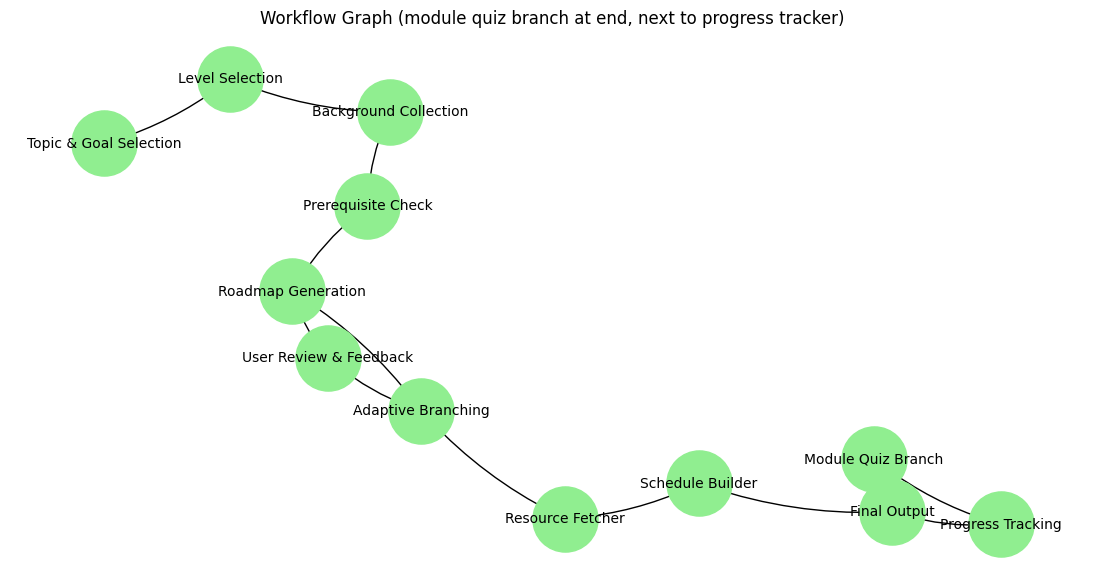

In [ ]:
# Visualize the workflow graph with module quiz branch at the end next to progress tracker
from IPython.display import HTML, display
import matplotlib.pyplot as plt

force_networkx = True  # Set True to use networkx fallback

# Updated workflow edges: module quiz branch moved to the end after final output and progress tracking
edges = [
    ("Topic & Goal Selection", "Level Selection"),
    ("Level Selection", "Background Collection"),
    ("Background Collection", "Prerequisite Check"),
    ("Prerequisite Check", "Roadmap Generation"),
    ("Roadmap Generation", "User Review & Feedback"),
    ("User Review & Feedback", "Adaptive Branching"),
    ("Adaptive Branching", "Roadmap Generation"),  # loop back for feedback
    ("Adaptive Branching", "Resource Fetcher"),
    ("Resource Fetcher", "Schedule Builder"),
    ("Schedule Builder", "Final Output"),
    ("Final Output", "Progress Tracking"),
    ("Final Output", "Module Quiz Branch"),
    ("Module Quiz Branch", "Progress Tracking"),
    # Optionally, Progress Tracking could be a terminal node
    # You can add more edges if you want to show feedback from quiz to progress
 ]

nodes = []
for a, b in edges:
    if a not in nodes: nodes.append(a)
    if b not in nodes: nodes.append(b)

id_map = {name: f"N{i}" for i, name in enumerate(nodes)}
mermaid_lines = []
for a, b in edges:
    mermaid_lines.append(f"{id_map[a]}[\"{a}\"] --> {id_map[b]}[\"{b}\"]")
mermaid_text = "flowchart LR\n" + "\n".join(mermaid_lines)

mermaid_html = f'''
<script src=\"https://cdn.jsdelivr.net/npm/mermaid@10/dist/mermaid.min.js\"></script>
<div class=\"mermaid\">{mermaid_text}</div>
<script>mermaid.initialize({{"startOnLoad":true}});</script>
'''
rendered_mermaid = False
if not force_networkx:
    try:
        display(HTML(mermaid_html))
        rendered_mermaid = True
    except Exception as mer_e:
        print('Mermaid inline rendering failed:', mer_e)
        rendered_mermaid = False

if force_networkx or not rendered_mermaid:
    try:
        import networkx as nx
    except Exception as e:
        nx = None
        print("Optional dependency 'networkx' not available; install it with pip install networkx for fallback drawing.")
    if nx is not None:
        nxg = nx.DiGraph()
        for n in nodes:
            nxg.add_node(n)
        for a, b in edges:
            nxg.add_edge(a, b)
        pos = nx.spring_layout(nxg, seed=42)
        plt.figure(figsize=(14, 7))
        nx.draw_networkx_nodes(nxg, pos, node_color='lightgreen', node_size=2200)
        nx.draw_networkx_labels(nxg, pos, font_size=10)
        nx.draw_networkx_edges(nxg, pos, arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.1')
        plt.title('Workflow Graph (module quiz branch at end, next to progress tracker)')
        plt.axis('off')
        plt.show()
    else:
        print('\nWorkflow adjacency list (fallback):')
        for src, dst in edges:
            print(f"{src} -> {dst}")

In [ ]:
import json
import os
import shutil
import tempfile
import datetime

def _save_state_json(state, filename='roadmap_state.json', schema_version=1):
    payload = {
        'meta': {
            'saved_at': datetime.datetime.utcnow().isoformat() + 'Z',
            'schema_version': schema_version,
        },
        'state': state.to_dict(),
    }
    tmp_fd, tmp_path = tempfile.mkstemp(prefix=filename + '.', suffix='.tmp')
    try:
        with os.fdopen(tmp_fd, 'w', encoding='utf-8') as f:
            json.dump(payload, f, ensure_ascii=False, indent=2)
        # create a .bak of existing file
        if os.path.exists(filename):
            shutil.copy2(filename, filename + '.bak')
        # atomic replace
        os.replace(tmp_path, filename)
        print(f'State saved atomically to {filename} (backup: {filename}.bak if existed)')
    except Exception as e:
        # cleanup
        try:
            os.remove(tmp_path)
        except Exception:
            pass
        print('Failed to save state:', e)

filename = 'roadmap_state.json'
if os.path.exists(filename):
    ans = input(f"'{filename}' exists — overwrite? (yes/no): ").strip().lower()
    if ans not in ('yes','y'):
        print('Save cancelled.')
    else:
        _save_state_json(state, filename)
else:
    _save_state_json(state, filename)

State saved atomically to roadmap_state.json (backup: roadmap_state.json.bak if existed)


C:\Users\Kaleb\AppData\Local\Temp\ipykernel_10416\2920883544.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'saved_at': datetime.datetime.utcnow().isoformat() + 'Z',


In [ ]:
import json
import os

def _load_state_json(filename='roadmap_state.json'):
    if not os.path.exists(filename):
        print(f'No state file found at {filename}')
        return None
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            payload = json.load(f)
        state_dict = payload.get('state') if isinstance(payload, dict) else None
        meta = payload.get('meta') if isinstance(payload, dict) else None
        s = RoadmapState.from_dict(state_dict or {})
        print('Loaded state:')
        if meta:
            print(f"  saved_at: {meta.get('saved_at')}, schema_version: {meta.get('schema_version')}")
        print(f"  topic: {s.topic}, goal: {s.goal}, estimated_level: {s.estimated_level}")
        return s
    except Exception as e:
        print('Failed to load state file:', e)
        return None

filename = 'roadmap_state.json'
loaded = _load_state_json(filename)
if loaded is not None:
    # confirm replace
    ans = input('Replace current `state` with the loaded state? (yes/no): ').strip().lower()
    if ans in ('yes','y'):
        state = loaded
        print('Current `state` replaced with loaded state.')
        # Offer to immediately resume the workflow from this loaded state
        resume_now = input('Resume workflow now from the loaded state (rebuild schedule and show final output)? (yes/no): ').strip().lower()
        if resume_now in ('yes','y'):
            # Ensure revised_roadmap exists (if not, regenerate quickly)
            if not getattr(state, 'revised_roadmap', None):
                state = node_generate_roadmap(state)
                state = node_review_feedback(state)
                if state.feedback.strip().lower() != 'no':
                    # If feedback exists, run adaptive branch
                    state = node_adaptive_branch(state)
                else:
                    state.revised_roadmap = state.roadmap
            # Enrich resources and rebuild schedule + final output
            try:
                state = node_resource_fetch(state)
            except Exception as e:
                print('Resource fetch step failed during resume:', e)
            try:
                state = node_schedule_builder(state)
            except Exception as e:
                print('Schedule builder failed during resume:', e)
            state = node_final_output(state)
    else:
        print('Load cancelled; current `state` unchanged.')
else:
    print('No state loaded.')

Loaded state:
  saved_at: 2025-11-19T06:30:04.151026Z, schema_version: 1
  topic: C++ for web dev, goal: Job, estimated_level: beginner


In [ ]:
# Optional UI: ipywidgets-based form to fill background fields and run workflow
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
except Exception:
    print("Optional UI requires 'ipywidgets'. Install with: pip install ipywidgets")
    raise

out = widgets.Output()

topic_in = widgets.Text(value='', description='Topic:', placeholder='e.g., Python for Data Science')
goal_in = widgets.Text(value='', description='Goal:', placeholder='e.g., Build a project')
level_in = widgets.Dropdown(options=['None', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2'], value='None', description='Level:')
learning_style_in = widgets.Dropdown(options=['', 'Videos', 'Reading', 'Projects', 'Interactive', 'Mixed'], value='', description='Style:')
available_time_in = widgets.Text(value='5 hours', description='Hours/week:', placeholder='e.g., 5 hours')

populate_btn = widgets.Button(description='Populate state (no run)', button_style='info')
run_btn = widgets.Button(description='Run workflow now', button_style='success')

status_lbl = widgets.Label(value='')

form = widgets.VBox([
    topic_in, goal_in, level_in, learning_style_in, available_time_in,
    widgets.HBox([populate_btn, run_btn]), status_lbl, out,
])

def _normalize_none(s):
    if s is None:
        return None
    s = str(s).strip()
    if not s:
        return None
    if s.lower() in ('none', 'n/a', 'na', 'null', 'nil'):
        return None
    return s

_learninging_styles = {'videos', 'reading', 'projects', 'interactive', 'mixed'}

def _normalize_state_fields(s):
    # s is a RoadmapState
    try:
        # Normalize learning_style
        if getattr(s, 'learning_style', None):
            if isinstance(s.learning_style, str) and s.learning_style.lower() in _learninging_styles:
                s.learning_style = s.learning_style.capitalize()
            elif isinstance(s.learning_style, str):
                s.learning_style = _normalize_none(s.learning_style)

        # Normalize available_time
        if getattr(s, 'available_time', None):
            import re
            m = re.search(r"(\d+)", str(s.available_time))
            if m:
                s.available_time = f"{m.group(1)} hours"
            else:
                # if they accidentally put a learning style in the available_time field, swap it
                if str(s.available_time).lower() in _learninging_styles:
                    if not getattr(s, 'learning_style', None):
                        s.learning_style = str(s.available_time).capitalize()
                    s.available_time = '5 hours'

        # If learning style missing but available_time contains one, move it
        if (not getattr(s, 'learning_style', None)) and getattr(s, 'available_time', None):
            if str(s.available_time).lower() in _learninging_styles:
                s.learning_style = str(s.available_time).capitalize()
                s.available_time = '5 hours'

    except Exception:
        pass
    return s

def _populate_state(_):
    global state
    try:
        if not isinstance(globals().get('state'), RoadmapState):
            state = RoadmapState()
    except Exception:
        state = RoadmapState()
    if topic_in.value:
        state.topic = topic_in.value
    if goal_in.value:
        state.goal = goal_in.value
    if level_in.value:
        state.estimated_level = level_in.value
    if learning_style_in.value:
        state.learning_style = _normalize_none(learning_style_in.value)
    if available_time_in.value:
        state.available_time = _normalize_none(available_time_in.value) or '5 hours'

    state = _normalize_state_fields(state)

    status_lbl.value = 'State populated (did not run workflow).'
    with out:
        clear_output()
        print('State now:')
        try:
            print(state.to_dict())
        except Exception:
            print({
                'topic': state.topic,
                'goal': state.goal,
                'level': state.estimated_level,
                'learning_style': state.learning_style,
                'available_time': state.available_time,
            })

def _run_workflow(_):
    global state
    try:
        if not isinstance(globals().get('state'), RoadmapState):
            state = RoadmapState()
    except Exception:
        state = RoadmapState()
    if topic_in.value:
        state.topic = topic_in.value
    if goal_in.value:
        state.goal = goal_in.value
    if level_in.value:
        state.estimated_level = level_in.value
    if learning_style_in.value:
        state.learning_style = _normalize_none(learning_style_in.value)
    if available_time_in.value:
        state.available_time = _normalize_none(available_time_in.value) or '5 hours'

    state = _normalize_state_fields(state)

    status_lbl.value = 'Running workflow — outputs will appear below (may call LLM).'
    with out:
        clear_output()
        try:
            # Prereq check
            state = node_prerequisite_check(state)
            # Loop: generate -> review -> (if feedback != 'no') regenerate
            while True:
                state = node_generate_roadmap(state)
                state = node_review_feedback(state)
                if state.feedback.strip().lower() == 'no':
                    break
                else:
                    print('\nFeedback provided — regenerating roadmap with requested changes...')
                    continue
            state.revised_roadmap = state.roadmap
            # Enrich resources and build schedule
            try:
                state = node_resource_fetch(state)
            except Exception as e:
                print('Resource fetch failed:', e)
            try:
                state = node_schedule_builder(state)
            except Exception as e:
                print('Schedule builder failed:', e)
            # Final output
            state = node_final_output(state)

            # Move module quiz branch to the end, after final output and before progress tracking
            take_quiz = input('Would you like to take a module quiz for progress tracking now? (yes/no): ').strip().lower()
            if take_quiz in ('yes', 'y'):
                state = node_module_quiz_branch(state)

            # Progress tracking summary
            print('\n--- PROGRESS TRACKING ---')
            print('Module progress:')
            for mod, info in state.module_progress.items():
                print(f"  {mod}: {info}")
            print('Quiz scores:')
            for score in state.quiz_scores:
                print(f"  {score}")

            status_lbl.value = 'Workflow completed.'
        except Exception as e:
            print('Workflow failed with error:', e)
            status_lbl.value = 'Workflow failed. See output above.'

try:
    populate_btn.on_click(_populate_state)
    run_btn.on_click(_run_workflow)
except Exception:
    pass

print('Optional interactive UI loaded. Use the form below to fill fields and run the workflow.')
display(form)


Optional interactive UI loaded. Use the form below to fill fields and run the workflow.
